# Data Preparation

---

In [1]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the training data

* ### Importing the data

In [2]:
train_labels = pd.read_csv('./train.csv')
train_labels.head()

,id,filename,label
0,0,train/img-0.jpeg,normal
1,1,train/img-1.jpeg,viral
2,2,train/img-2.jpeg,viral
3,3,train/img-3.jpeg,bacterial
4,4,train/img-4.jpeg,viral


In [3]:
print('Size of the training set:', train_labels.shape[0])

Size of the training set: 1127


In [4]:
# Checking the distribution of the labels

train_labels['label'].value_counts()

normal       350
bacterial    350
viral        350
covid         77
Name: label, dtype: int64

This .csv file allows us to connect the chest X-rays images to their label. Let's combine everything in one table.

* ### Combining the images and their label in one table

Let's create a table containing the `id`, `pix_value` and `label` of each chest X-rays at hand.

In [5]:
from PIL import Image

n_rows = train_labels.shape[0]
img_list = [np.array(Image.open('./train/' + train_labels.loc[i, 'filename'])) for i in range(n_rows)]

In [6]:
X = train_labels.drop(columns= ['filename'])
X['pix_value'] = img_list
X = X[['id', 'pix_value', 'label']]
X.head()

,id,pix_value,label
0,0,"[[100, 90, 79, 73, 70, 66, 66, 69, 73, 73, 73,...",normal
1,1,"[[110, 130, 128, 124, 141, 142, 130, 132, 142,...",viral
2,2,"[[119, 119, 118, 116, 114, 112, 109, 108, 104,...",viral
3,3,"[[5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,...",bacterial
4,4,"[[109, 108, 106, 107, 108, 109, 108, 106, 109,...",viral


In [7]:
# Visualizing the shape of one image metadata

X.loc[0, 'pix_value'].shape

(965, 1120)

* ### Visualizing some chest X-rays images

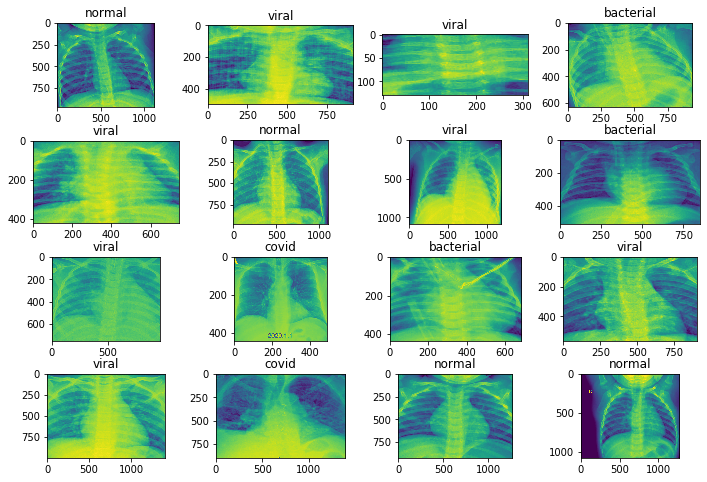

In [18]:
# Visualizing the first 16 chest X-rays images

fig, axs = plt.subplots(4, 4, figsize= (12, 8))
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].imshow(X.loc[i, 'pix_value'])
    axs[i].set_title(X.loc[i, 'label'])
plt.subplots_adjust(hspace= 0.4)

# Data Preprocessing

Given that the images are of different sizes and qualities, let's preprocess the data to improve uniformity.

* ### Resizing our images 

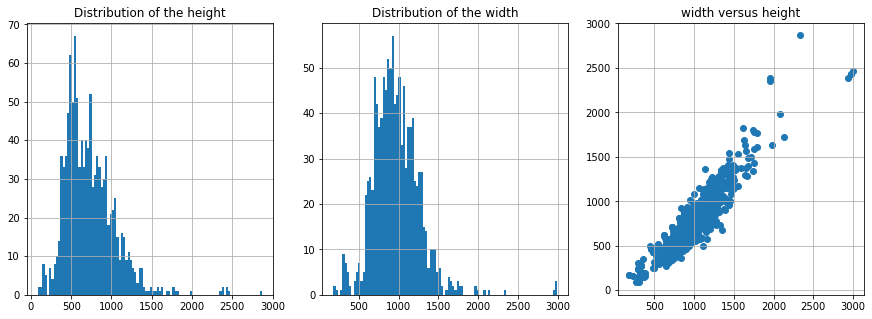

In [9]:
# Checking the distribution of the height and width of our images

H = []
W = []

for k in range(X.shape[0]):
    shape = X.loc[k, 'pix_value'].shape
    H.append(shape[0])
    W.append(shape[1])
    
fig, axs = plt.subplots(1, 3, figsize= (15, 5))
axs[0].hist(H, bins= 100)
axs[0].set_title('Distribution of the height')
axs[0].grid()
axs[1].hist(W, bins= 100)
axs[1].set_title('Distribution of the width')
axs[1].grid()
axs[2].scatter(W, H)
axs[2].set_title('width versus height')
axs[2].grid()

The relationship between the width and the height of the images in our dataset is quite linear. We can expect that resizing our data won't distort them too much.

In [10]:
# Defining the shape of the resizing

new_W = int(np.median(W))
new_H = int(H[W.index(np.median(W))])
print('Resizing:', (new_W, new_H))

Resizing: (936, 755)


In [13]:
# Resizing our dataset
import cv2

resized_pix_list = []
for k in range(X.shape[0]):
    dim = (new_W, new_H)
    resized_pix_list.append(cv2.resize(X.loc[k, 'pix_value'], dim))
X = X.assign(resized_pix = resized_pix_list)

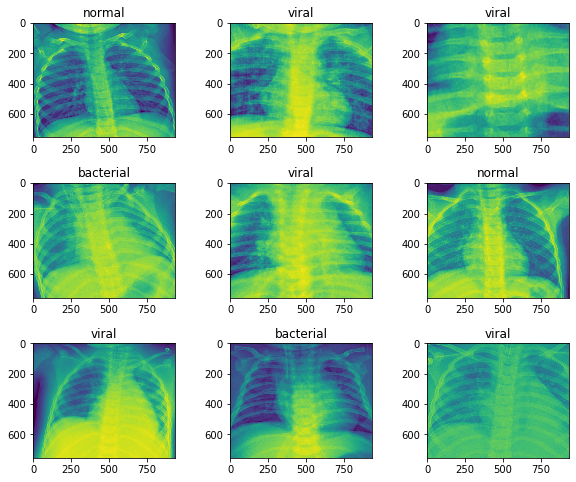

In [17]:
# Displaying the nine first resized img

fig, axs = plt.subplots(3, 3, figsize= (10, 8))
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].imshow(X.loc[i, 'resized_pix'])
    axs[i].set_title(X.loc[i, 'label'])
plt.subplots_adjust(hspace= 0.4)

* ### Denoising the images

In this section, we are going to use a gaussian smooth to remove potential unwanted noise in our data. We will later compare if our model performs better with this treatment.

In [35]:
blurred_pix_list = []
for k in range(X.shape[0]):
    blurred_pix_list.append(cv2.GaussianBlur(X.loc[k, 'resized_pix'], (5, 5), 0))
X = X.assign(blurred_pix = blurred_pix_list)

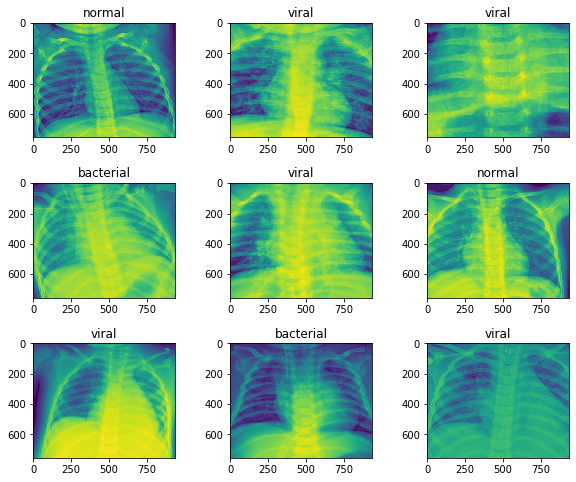

In [36]:
# Displaying the nine first blurred img

fig, axs = plt.subplots(3, 3, figsize= (10, 8))
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].imshow(X.loc[i, 'blurred_pix'])
    axs[i].set_title(X.loc[i, 'label'])
plt.subplots_adjust(hspace= 0.4)

The effects of the blurring are not clear for all of the images displayed, but we can notice a difference for the last image. We can expect similar results on other images and we will assess the relevancy of this treatment later.

* ### Saving our processed dataset 

In [37]:
X = X[['id', 'pix_value', 'resized_pix', 'blurred_pix', 'label']]
X.head()

,id,pix_value,resized_pix,blurred_pix,label
0,0,"[[100, 90, 79, 73, 70, 66, 66, 69, 73, 73, 73,...","[[99, 87, 76, 71, 66, 66, 70, 73, 73, 73, 74, ...","[[93, 88, 80, 73, 70, 70, 71, 72, 73, 74, 75, ...",normal
1,1,"[[110, 130, 128, 124, 141, 142, 130, 132, 142,...","[[110, 129, 128, 124, 139, 142, 131, 132, 140,...","[[124, 126, 128, 131, 135, 136, 135, 135, 137,...",viral
2,2,"[[119, 119, 118, 116, 114, 112, 109, 108, 104,...","[[119, 119, 119, 119, 119, 119, 118, 118, 117,...","[[119, 119, 119, 119, 119, 118, 118, 118, 117,...",viral
3,3,"[[5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,...","[[5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,...","[[5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,...",bacterial
4,4,"[[109, 108, 106, 107, 108, 109, 108, 106, 109,...","[[109, 108, 107, 106, 107, 108, 109, 108, 107,...","[[109, 109, 108, 108, 108, 108, 108, 107, 106,...",viral


In [38]:
X.to_csv('processed_train.csv', index= False)